In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install ace_tools_open
!pip install ace_tools
import ace_tools_open as tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 구글 코랩에 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
df = pd.read_csv('/content/final_df.csv')

In [ ]:
# 📌 날짜 변수를 먼저 변환 (datetime 타입 변환)
df['대여일자'] = pd.to_datetime(df['대여일자'], errors='coerce')

# 📌 공휴일 효과를 숫자로 변환 (문자열 → 숫자)
df['공휴일 효과'] = df['공휴일 효과'].map({'주중': 0, '주말': 1, '공휴일': 1}).fillna(0).astype(int)

# 📌 날짜 관련 변수 생성
df['요일'] = df['대여일자'].dt.dayofweek
df['연도'] = df['대여일자'].dt.year
df['월'] = df['대여일자'].dt.month

# 📌 강수 관련 변수 생성
df['전날_강수여부'] = df.groupby('대여소')['강수여부'].shift(1).fillna(0).astype(int)
df['최근3일_강수횟수'] = df.groupby('대여소')['강수여부'].transform(lambda x: x.rolling(3, min_periods=1).sum()).fillna(0)
df['최근7일_강수비율'] = df.groupby('대여소')['강수여부'].transform(lambda x: x.rolling(7, min_periods=1).mean()).fillna(0)
df['강수여부_주간누적'] = df.groupby('대여소')['강수여부'].transform(lambda x: x.rolling(7, min_periods=1).sum()).fillna(0)
df['강수여부_월별평균'] = df.groupby('월')['강수여부'].transform('mean').fillna(0)

# 📌 공휴일 관련 변수 생성
df['공휴일_세분화'] = df['공휴일 효과']
df.loc[(df['공휴일 효과'] == 1) & (df['요일'].isin([5, 6])), '공휴일_세분화'] = 3  # 연휴
df.loc[(df['공휴일 효과'] == 1) & (~df['요일'].isin([5, 6])), '공휴일_세분화'] = 2  # 공휴일
df['전날_공휴일'] = df.groupby('대여소')['공휴일 효과'].shift(1).fillna(0).astype(int)
df['다음날_공휴일'] = df.groupby('대여소')['공휴일 효과'].shift(-1).fillna(0).astype(int)
df['연휴_길이'] = df.groupby('대여소')['공휴일 효과'].transform(lambda x: x.rolling(3, min_periods=1).sum()).fillna(0)
df['연휴_평균이용량_차이'] = (df.groupby('대여소')['이용건수'].transform(lambda x: x.rolling(3, min_periods=1).mean()) - df.groupby('대여소')['이용건수'].transform('mean')).fillna(0)
df['공휴일_다음날_증감률'] = ((df['이용건수'] - df.groupby('대여소')['이용건수'].shift(1)) / df.groupby('대여소')['이용건수'].shift(1)).fillna(0)

# 📌 유동인구 관련 변수 생성
df['전날_유동인구_범례'] = df.groupby('대여소')['유동인구_범례'].shift(1).fillna(df['유동인구_범례'].mean())
df['7일_이동평균_유동인구'] = df.groupby('대여소')['유동인구_범례'].transform(lambda x: x.rolling(7, min_periods=1).mean()).fillna(0)
df['최근3일_평균_유동인구'] = df.groupby('대여소')['유동인구_범례'].transform(lambda x: x.rolling(3, min_periods=1).mean()).fillna(0)
df['유동인구_증감률'] = df.groupby('대여소')['유동인구_범례'].pct_change().fillna(0)
df['유동인구_평균차이'] = (df['유동인구_범례'] - df.groupby('대여소')['유동인구_범례'].transform('mean')).fillna(0)
df['유동인구_변동성지수'] = df.groupby('대여소')['유동인구_범례'].transform(lambda x: x.rolling(7, min_periods=1).std()).fillna(0)
df['유동인구_급증여부'] = ((df.groupby('대여소')['유동인구_범례'].diff() / df.groupby('대여소')['유동인구_범례'].shift(1) > 0.2).astype(int)).fillna(0)

# 📌 시계열 관련 변수 생성
df['전날_이용건수'] = df.groupby('대여소')['이용건수'].shift(1).fillna(df['이용건수'].mean())
df['7일전_이용건수'] = df.groupby('대여소')['이용건수'].shift(7).fillna(df['이용건수'].mean())
df['주간_이동평균_이용건수'] = df.groupby('대여소')['이용건수'].transform(lambda x: x.rolling(7, min_periods=1).mean()).fillna(0)
df['월별_이용량_변화율'] = (df.groupby('월')['이용건수'].transform('mean') - df['이용건수']).fillna(0)
df['연속_이용증가일수'] = (
    df.groupby('대여소', group_keys=False)['이용건수']
    .apply(lambda x: (x.diff() > 0).astype(int).cumsum())
    .reset_index(drop=True)
    .fillna(0)
    .astype(int)
)

from sklearn.preprocessing import LabelEncoder
# 📌 대여소 관련 변수 생성
encoder = LabelEncoder()
df['대여소_인코딩'] = encoder.fit_transform(df['대여소'])


tools.display_dataframe_to_user(name="확장된 데이터", dataframe=df)


확장된 데이터


In [ ]:
df.to_csv("변수추가.csv", index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113836 entries, 0 to 113835
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   대여일자           113836 non-null  datetime64[ns]
 1   대여소            113836 non-null  object        
 2   위도             113836 non-null  float64       
 3   경도             113836 non-null  float64       
 4   설치시기           113836 non-null  object        
 5   강수여부           113836 non-null  int64         
 6   공휴일 효과         113836 non-null  int64         
 7   유동인구_범례        113836 non-null  float64       
 8   이용건수           113836 non-null  int64         
 9   대여소별_조정가중이용지수  113836 non-null  float64       
 10  요일             113836 non-null  int32         
 11  연도             113836 non-null  int32         
 12  월              113836 non-null  int32         
 13  전날_강수여부        113836 non-null  int64         
 14  최근3일_강수횟수      113836 non-null  float64       
 15  

In [ ]:
# 형 변환 수행

# 범주형으로 변환할 변수들 정의
categorical_columns = ['강수여부', '전날_강수여부', '유동인구_급증여부', '공휴일 효과', '공휴일_세분화', '전날_공휴일', '다음날_공휴일']

# 범주형 변환
df[categorical_columns] = df[categorical_columns].astype('category')

# 설치시기를 datetime으로 변환
df['설치시기'] = pd.to_datetime(df['설치시기'], errors='coerce')

# 변환된 데이터 확인
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113836 entries, 0 to 113835
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   대여일자           113836 non-null  datetime64[ns]
 1   대여소            113836 non-null  object        
 2   위도             113836 non-null  float64       
 3   경도             113836 non-null  float64       
 4   설치시기           113836 non-null  datetime64[ns]
 5   강수여부           113836 non-null  category      
 6   공휴일 효과         113836 non-null  category      
 7   유동인구_범례        113836 non-null  float64       
 8   이용건수           113836 non-null  int64         
 9   대여소별_조정가중이용지수  113836 non-null  float64       
 10  요일             113836 non-null  int32         
 11  연도             113836 non-null  int32         
 12  월              113836 non-null  int32         
 13  전날_강수여부        113836 non-null  category      
 14  최근3일_강수횟수      113836 non-null  float64       
 15  

In [ ]:
# '유동인구_범례'를 범주형으로 변환
df['유동인구_범례'] = df['유동인구_범례'].astype('category')

# 변환 후 데이터 확인
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113836 entries, 0 to 113835
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   대여일자           113836 non-null  datetime64[ns]
 1   대여소            113836 non-null  object        
 2   위도             113836 non-null  float64       
 3   경도             113836 non-null  float64       
 4   설치시기           113836 non-null  datetime64[ns]
 5   강수여부           113836 non-null  category      
 6   공휴일 효과         113836 non-null  category      
 7   유동인구_범례        113836 non-null  category      
 8   이용건수           113836 non-null  int64         
 9   대여소별_조정가중이용지수  113836 non-null  float64       
 10  요일             113836 non-null  int32         
 11  연도             113836 non-null  int32         
 12  월              113836 non-null  int32         
 13  전날_강수여부        113836 non-null  category      
 14  최근3일_강수횟수      113836 non-null  float64       
 15  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# 1️⃣ 날짜 변환 및 정렬
df = df.sort_values(by=['대여일자', '대여소'])

# 2️⃣ Train-Test Split (2021~2023년 학습, 2024년 검증, 2025~2026년 예측)
train_data = df[df['연도'] < 2024]  # 2021~2023년 학습
test_data = df[df['연도'] == 2024]  # 2024년 검증
future_data = df[df['연도'] >= 2025]  # 2025~2026년 예측

# 3️⃣ LightGBM용 데이터 준비 (범주형 변수 포함)
features = ['대여소_인코딩', '위도', '경도', '요일', '월', '강수여부', '공휴일 효과',
            '유동인구_범례', '전날_강수여부', '전날_공휴일', '다음날_공휴일', '전날_이용건수',
            '7일전_이용건수', '주간_이동평균_이용건수', '월별_이용량_변화율', '연속_이용증가일수']
target = '이용건수'

X_train, X_val, y_train, y_val = train_test_split(
    train_data[features], train_data[target], test_size=0.2, random_state=42
)

# 4️⃣ LSTM용 데이터 준비 (정규화 필요)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[features])
scaled_test = scaler.transform(test_data[features])

# 5️⃣ Prophet용 데이터 준비 (날짜 + 이용건수만 필요)
prophet_train = train_data[['대여일자', '이용건수']].rename(columns={'대여일자': 'ds', '이용건수': 'y'})

# 전처리 완료!
print("✅ 데이터 전처리 완료!")

✅ 데이터 전처리 완료!


In [ ]:
# LightGBM 학습 및 예측 (수정 버전)

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import pandas as pd

# 1️⃣ LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

# 2️⃣ 모델 학습 (2021~2023 학습, 2024 검증)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae')

# 3️⃣ 검증 데이터 예측
y_pred_lgb = lgb_model.predict(X_val)

# 4️⃣ 성능 평가 (MAE)
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)

# 5️⃣ 피처 중요도 확인
feature_importance = pd.DataFrame({'Feature': features, 'Importance': lgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 6️⃣ 중요도가 낮은 피처 제거 후 다시 학습
low_importance_threshold = feature_importance['Importance'].quantile(0.2)
low_importance_features = feature_importance[feature_importance['Importance'] < low_importance_threshold]['Feature'].tolist()
filtered_features = [f for f in features if f not in low_importance_features]

X_train_filtered = X_train[filtered_features]
X_val_filtered = X_val[filtered_features]

lgb_model_filtered = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

lgb_model_filtered.fit(X_train_filtered, y_train, eval_set=[(X_val_filtered, y_val)], eval_metric='mae')
y_pred_lgb_filtered = lgb_model_filtered.predict(X_val_filtered)
mae_lgb_filtered = mean_absolute_error(y_val, y_pred_lgb_filtered)

# 7️⃣ 성능 비교 출력
print(f"✅ LightGBM MAE (Before Feature Selection): {mae_lgb:.4f}")
print(f"✅ LightGBM MAE (After Feature Selection): {mae_lgb_filtered:.4f}")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 67395, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 48.654707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

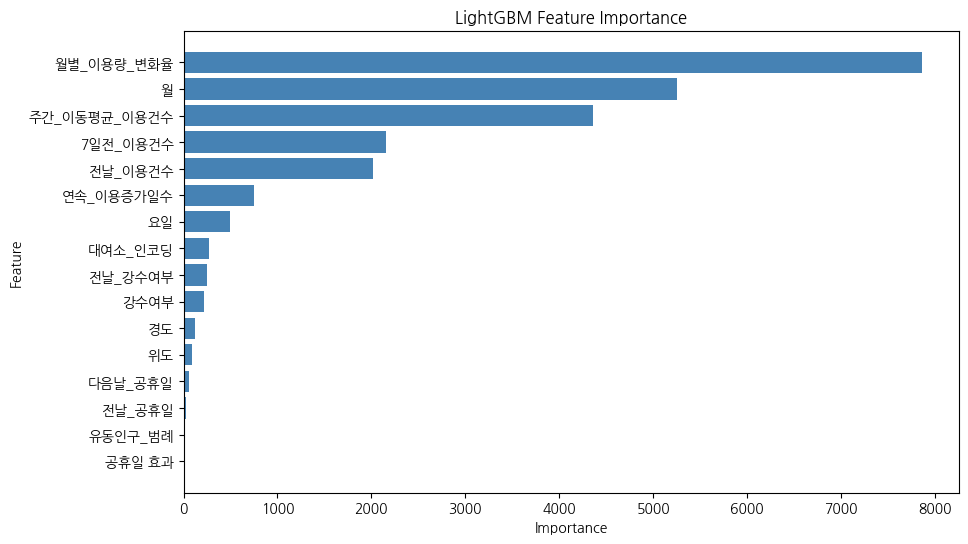

In [ ]:
import matplotlib.pyplot as plt

# ✅ 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 정렬
plt.show()

In [ ]:
filtered_features

['대여소_인코딩',
 '위도',
 '경도',
 '요일',
 '월',
 '강수여부',
 '전날_강수여부',
 '다음날_공휴일',
 '전날_이용건수',
 '7일전_이용건수',
 '주간_이동평균_이용건수',
 '월별_이용량_변화율',
 '연속_이용증가일수']

In [ ]:
# Prophet 모델 학습 및 2024년 검증 (Feature Selection 적용)

from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# 1️⃣ Feature Selection 적용된 데이터 준비 (2021~2023년 학습 데이터)
prophet_train = train_data[train_data['연도'] <= 2023][['대여일자', '이용건수'] + filtered_features].rename(columns={'대여일자': 'ds', '이용건수': 'y'})

# 2️⃣ 2024년 검증 데이터 준비 (동일한 Feature Set 적용)
prophet_test = test_data[test_data['연도'] == 2024][['대여일자', '이용건수'] + filtered_features].rename(columns={'대여일자': 'ds', '이용건수': 'y'})

# 3️⃣ Prophet 모델 설정
prophet_model = Prophet(
    yearly_seasonality=True,  # 연간 계절성 반영
    weekly_seasonality=True,  # 주간 계절성 반영
    daily_seasonality=False   # 일별 계절성은 사용하지 않음
)

# 4️⃣ Feature Selection 적용된 피처를 Prophet에 추가
for feature in filtered_features:
    prophet_model.add_regressor(feature)

# 5️⃣ 모델 학습 (2021~2023년 데이터 사용)
prophet_model.fit(prophet_train)

# 6️⃣ 2024년 예측 수행
forecast_2024 = prophet_model.predict(prophet_test[['ds'] + filtered_features])

# 7️⃣ Prophet 성능 평가 (2024년 검증)
mae_prophet = mean_absolute_error(prophet_test['y'], forecast_2024['yhat'])

# 8️⃣ 결과 출력
print(f"✅ Prophet MAE (2024 검증, Feature Selection 적용): {mae_prophet:.4f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/dm51vm0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/lzx4ayrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94827', 'data', 'file=/tmp/tmp9dw32dcw/dm51vm0b.json', 'init=/tmp/tmp9dw32dcw/lzx4ayrc.json', 'output', 'file=/tmp/tmp9dw32dcw/prophet_model1l8m5t6d/prophet_model-20250218041121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:11:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet MAE (2024 검증, Feature Selection 적용): 1.6793


In [ ]:
# XGBoost 모델 학습 및 2024년 검증

import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# 1️⃣ XGBoost 학습 데이터 준비 (2021~2023년 데이터 사용)
X_train_xgb = train_data[train_data['연도'] <= 2023][filtered_features]
y_train_xgb = train_data[train_data['연도'] <= 2023]['이용건수']

# 2️⃣ 2024년 검증 데이터 준비
X_val_xgb = test_data[test_data['연도'] == 2024][filtered_features]
y_val_xgb = test_data[test_data['연도'] == 2024]['이용건수']

# 3️⃣ XGBoost 모델 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mae",  # Specify eval_metric here
    enable_categorical=True
)

# 4️⃣ 모델 학습 (2021~2023년 데이터 사용)
# Define the early stopping callback
es_callback = xgb.callback.EarlyStopping(rounds=50, metric_name='mae', save_best=True)

# Remove 'callbacks' from fit() and use it within the eval_set
xgb_model.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],

    verbose=100,
)

# 5️⃣ 2024년 검증 데이터 예측
y_pred_xgb = xgb_model.predict(X_val_xgb)

# 6️⃣ XGBoost 성능 평가 (2024년 검증)
mae_xgb = mean_absolute_error(y_val_xgb, y_pred_xgb)

# 7️⃣ 결과 출력
print(f"✅ XGBoost MAE (2024 검증): {mae_xgb:.4f}")

[0]	validation_0-mae:31.53965
[100]	validation_0-mae:2.41185
[200]	validation_0-mae:1.87187
[300]	validation_0-mae:1.72751
[400]	validation_0-mae:1.64683
[500]	validation_0-mae:1.60033
[600]	validation_0-mae:1.56156
[700]	validation_0-mae:1.53701
[800]	validation_0-mae:1.51806
[900]	validation_0-mae:1.50085
[999]	validation_0-mae:1.49075
✅ XGBoost MAE (2024 검증): 1.4907


In [ ]:
import itertools
# ✅ 2025년 날짜 생성
date_range_2025 = pd.date_range(start="2025-01-01", end="2025-12-31", freq="D")

# ✅ 모든 대여소 목록 가져오기
unique_stations = train_data["대여소_인코딩"].unique()

# ✅ 대여소별 날짜 조합 생성
X_2025_list = []
for station in unique_stations:
    temp_df = pd.DataFrame({"대여일자": date_range_2025})
    temp_df["대여소_인코딩"] = station
    X_2025_list.append(temp_df)

# ✅ 하나의 데이터프레임으로 합치기
X_2025 = pd.concat(X_2025_list, ignore_index=True)

# ✅ 날짜 관련 피처 추가
X_2025["연도"] = X_2025["대여일자"].dt.year
X_2025["월"] = X_2025["대여일자"].dt.month
X_2025["요일"] = X_2025["대여일자"].dt.weekday  # 월(0) ~ 일(6)

# ✅ 계절성 반영 (월별 평균 패턴 적용)
train_data_numeric = train_data.copy()
for col in ["강수여부", "전날_강수여부", "월별_이용량_변화율", "연속_이용증가일수"]:
    if train_data_numeric[col].dtype.name == "category":
        train_data_numeric[col] = train_data_numeric[col].astype("int")

monthly_avg = train_data_numeric.groupby("월")[["강수여부", "전날_강수여부", "월별_이용량_변화율", "연속_이용증가일수"]].mean().reset_index()
X_2025 = X_2025.merge(monthly_avg, on="월", how="left")

# ✅ 공휴일 반영 (직접 계산)
X_2025["다음날_공휴일"] = 0
holiday_dates = train_data[train_data["다음날_공휴일"] == 1]["대여일자"].dt.dayofyear.unique()
X_2025.loc[X_2025["대여일자"].dt.dayofyear.isin(holiday_dates), "다음날_공휴일"] = 1

# ✅ Prophet을 사용하여 `전날_이용건수`, `7일전_이용건수` 예측 (대여소별 예측)
prophet_predictions = []
for station in unique_stations:
    prophet_train = train_data[train_data["대여소_인코딩"] == station][["대여일자", "이용건수"]].rename(columns={"대여일자": "ds", "이용건수": "y"})
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(prophet_train)
    future_dates = prophet_model.make_future_dataframe(periods=365)
    forecast = prophet_model.predict(future_dates)
    forecast["대여소_인코딩"] = station
    forecast = forecast[["ds", "대여소_인코딩", "yhat"]].rename(columns={"ds": "대여일자", "yhat": "전날_이용건수"})
    prophet_predictions.append(forecast)

# ✅ Prophet 예측값 반영
prophet_predictions_df = pd.concat(prophet_predictions, ignore_index=True)
X_2025 = X_2025.merge(prophet_predictions_df, on=["대여일자", "대여소_인코딩"], how="left")

# ✅ 7일전 이용건수 예측값 추가
X_2025["7일전_이용건수"] = X_2025["전날_이용건수"].shift(7).fillna(method="bfill")

# ✅ 주간 이동평균 이용건수 (대여소별 이동평균 적용)
X_2025["주간_이동평균_이용건수"] = train_data.groupby(["대여소_인코딩", train_data["대여일자"].dt.isocalendar().week])["이용건수"].transform("mean")

# ✅ 대여소별 위도, 경도 정보 추가
station_geo_info = train_data[["대여소_인코딩", "위도", "경도"]].drop_duplicates()

# ✅ X_2025에 대여소별 위도, 경도 추가
X_2025 = X_2025.merge(station_geo_info, on="대여소_인코딩", how="left")
dates_2025 = X_2025["대여일자"]
# ✅ 불필요한 컬럼 제거
X_2025 = X_2025[filtered_features]

# ✅ 최종 확인
print("✅ 수정된 X_2025 shape:", X_2025.shape)
print("✅ 수정된 X_2025 첫 5개 행:\n", X_2025.head())

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/fjugdfp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/m9j5kxrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29976', 'data', 'file=/tmp/tmp9dw32dcw/fjugdfp7.json', 'init=/tmp/tmp9dw32dcw/m9j5kxrm.json', 'output', 'file=/tmp/tmp9dw32dcw/prophet_modelpzzox5cj/prophet_model-20250218041305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/ffpf_u3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/3c5o1bcv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

✅ 수정된 X_2025 shape: (28835, 13)
✅ 수정된 X_2025 첫 5개 행:
    대여소_인코딩         위도          경도  요일  월      강수여부   전날_강수여부  다음날_공휴일  \
0        0  37.535824  127.094162   2  1  0.493218  0.473737        1   
1        0  37.535824  127.094162   3  1  0.493218  0.473737        1   
2        0  37.535824  127.094162   4  1  0.493218  0.473737        1   
3        0  37.535824  127.094162   5  1  0.493218  0.473737        0   
4        0  37.535824  127.094162   6  1  0.493218  0.473737        1   

   전날_이용건수  7일전_이용건수  주간_이동평균_이용건수  월별_이용량_변화율   연속_이용증가일수  
0      NaN       NaN     12.000000    3.241865  180.219336  
1      NaN       NaN      2.000000    3.241865  180.219336  
2      NaN       NaN      2.666667    3.241865  180.219336  
3      NaN       NaN      5.666667    3.241865  180.219336  
4      NaN       NaN     12.333333    3.241865  180.219336  


<ipython-input-14-e37645cea85a>:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_2025["7일전_이용건수"] = X_2025["전날_이용건수"].shift(7).fillna(method="bfill")


In [ ]:
# ✅ 1. 2021~2023년 학습 데이터와 2024년 검증 데이터를 합쳐 최종 학습 데이터 생성
X_train_final = pd.concat([X_train_filtered, X_val_filtered], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

# ✅ 2. 2025년 예측을 위한 데이터 준비 (2025년 데이터를 위한 feature set)
X_2025 = X_2025[filtered_features]  # 선택된 feature만 사용

# ✅ 3. 최종 확인
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"X_2025 shape: {X_2025.shape}")

X_train_final shape: (84244, 13)
y_train_final shape: (84244,)
X_2025 shape: (28835, 13)


In [ ]:
# ✅ 모든 category 변수 찾기
categorical_features = X_train_final.select_dtypes(include=['category', 'object']).columns.tolist()

# ✅ LightGBM & XGBoost에서 categorical_feature가 일관되도록 설정
for col in categorical_features:
    X_train_final[col] = X_train_final[col].astype("category")
    X_2025[col] = X_2025[col].astype("category")

# ✅ LightGBM 모델 설정
lgb_model_final = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    categorical_feature=categorical_features  # ✅ LightGBM에서 카테고리 변수 자동 적용
)

# ✅ XGBoost 모델 설정 (enable_categorical=True 추가)
xgb_model_final = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    enable_categorical=True  # ✅ XGBoost에서 카테고리 변수 자동 적용
)

# ✅ LightGBM & XGBoost 학습 (로그 변환 없이)
lgb_model_final.fit(X_train_final, y_train_final)
xgb_model_final.fit(X_train_final, y_train_final)

# ✅ 2025년 예측 수행 (예측 후 exp 변환 없이)
y_pred_lgb_2025 = lgb_model_final.predict(X_2025)
y_pred_xgb_2025 = xgb_model_final.predict(X_2025)

# ✅ 확인
print("✅ 변환된 카테고리 변수:", categorical_features)


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=다음날_공휴일, categorical_column=7 will be ignored. Current value: categorical_feature=다음날_공휴일
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 113079, number of used features: 13
[LightGBM] [Info] Start training from score 54.187500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
# ✅ Prophet 모델 새로 생성 (튜닝 적용)
prophet_model_final = Prophet(
    changepoint_prior_scale=0.01,   # 트렌드 변화를 부드럽게 조정
    seasonality_prior_scale=10.0,   # 계절성 반영 강도
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative"  # 계절성을 비율적으로 반영하여 변화 감지 개선
)

# ✅ Prophet 데이터 준비
prophet_train_final = train_data[["대여일자", "이용건수"]].rename(columns={"대여일자": "ds", "이용건수": "y"})

# ✅ Prophet 모델 학습
prophet_model_final.fit(prophet_train_final)

# ✅ 예측 수행
future_2025 = prophet_model_final.make_future_dataframe(periods=len(X_2025))
forecast_2025 = prophet_model_final.predict(future_2025)

# ✅ 음수값 보정 (clip 사용)
y_pred_prophet_2025 = forecast_2025["yhat"].clip(lower=0).values[:len(X_2025)]

# ✅ 결과 확인
print(f"📌 Prophet 예측 후 값 범위: {y_pred_prophet_2025.min()} ~ {y_pred_prophet_2025.max()}")

# ✅ 최종 앙상블 예측
ensemble_2025 = (y_pred_lgb_2025 + y_pred_xgb_2025 + y_pred_prophet_2025) / 3

# ✅ 2025년 예측 결과 데이터프레임 생성 (대여소 이름 포함)
df_2025_pred = pd.DataFrame({
    "대여소_인코딩": X_2025["대여소_인코딩"],
    "대여일자": dates_2025,
    "LightGBM_예측": y_pred_lgb_2025,
    "XGBoost_예측": y_pred_xgb_2025,
    "Prophet_예측": y_pred_prophet_2025,
    "앙상블_최종예측": ensemble_2025
})

# ✅ 대여소 인코딩 → 대여소 이름 매핑 추가
station_mapping = train_data[["대여소_인코딩", "대여소"]].drop_duplicates()
df_2025_pred = df_2025_pred.merge(station_mapping, on="대여소_인코딩", how="left")

# ✅ "대여소_인코딩" 컬럼 제거하고 "대여소" 컬럼을 앞으로 정렬
df_2025_pred = df_2025_pred[["대여소", "대여일자", "LightGBM_예측", "XGBoost_예측", "Prophet_예측", "앙상블_최종예측"]]

# ✅ 최종 확인
print("✅ 2025년 대여소별 일별 예측 완료! (대여소 이름 표시)")
df_2025_pred.head(20)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/tilqcwlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/m5gxtcgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76039', 'data', 'file=/tmp/tmp9dw32dcw/tilqcwlo.json', 'init=/tmp/tmp9dw32dcw/m5gxtcgj.json', 'output', 'file=/tmp/tmp9dw32dcw/prophet_modela0a9zjo9/prophet_model-20250218060823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📌 Prophet 예측 후 값 범위: 13.136759641330082 ~ 244.68045977498932
✅ 2025년 대여소별 일별 예측 완료! (대여소 이름 표시)


대여소       대여일자  LightGBM_예측  XGBoost_예측  Prophet_예측   앙상블_최종예측
0   강변역 4번출구 뒤 2025-01-01    22.526663   21.473543   19.398696  21.132967
1   강변역 4번출구 뒤 2025-01-02    22.723937   19.211271   15.258022  19.064410
2   강변역 4번출구 뒤 2025-01-03    22.854391   20.012300   13.499408  18.788700
3   강변역 4번출구 뒤 2025-01-04    22.994432   19.065989   17.437556  19.832659
4   강변역 4번출구 뒤 2025-01-05    22.477694   20.835970   18.191917  20.501860
5   강변역 4번출구 뒤 2025-01-06    22.748855   20.857422   19.100613  20.902297
6   강변역 4번출구 뒤 2025-01-07    22.352972   21.057405   19.054771  20.821716
7   강변역 4번출구 뒤 2025-01-08    22.838142   19.561977   20.160730  20.853617
8   강변역 4번출구 뒤 2025-01-09    22.581745   21.740555   15.872839  20.065046
9   강변역 4번출구 뒤 2025-01-10    22.050490   20.559559   13.959337  18.856462
10  강변역 4번출구 뒤 2025-01-11    23.113319   19.019768   17.759618  19.964235
11  강변역 4번출구 뒤 2025-01-12    22.713085   20.252581   18.351968  20.439211
12  강변역 4번출구 뒤 2025-01-13    22.584738   20.258232   19.099724  20.647565
13  강변역 4번출구 뒤 2025-01-14    22.400509   18.117102   18.894993  19.804201
14  강변역 4번출구 뒤 2025-01-15    22.838142   19.561977   19.862183  20.754101
15  강변역 4번출구 뒤 2025-01-16    23.132683   19.379253   15.426449  19.312795
16  강변역 4번출구 뒤 2025-01-17    22.574455   22.427284   13.403544  19.468428
17  강변역 4번출구 뒤 2025-01-18    22.713085   20.852831   17.155553  20.240489
18  강변역 4번출구 뒤 2025-01-19    22.694623   18.242216   17.716393  19.551078
19  강변역 4번출구 뒤 2025-01-20    22.931221   18.497829   18.470308  19.966453

In [ ]:
df_2025_pred.describe()

대여일자   LightGBM_예측    XGBoost_예측  \
count                          28835  28835.000000  28835.000000   
mean   2025-07-02 00:00:00.000000256     46.972021     47.583492   
min              2025-01-01 00:00:00     19.832839     18.117102   
25%              2025-04-02 00:00:00     38.578496     40.384396   
50%              2025-07-02 00:00:00     51.779085     52.736233   
75%              2025-10-01 00:00:00     56.362343     56.469252   
max              2025-12-31 00:00:00     63.846346     64.497635   
std                              NaN     12.440069     12.602674   

         Prophet_예측      앙상블_최종예측  
count  28835.000000  28835.000000  
mean     116.349148     70.301553  
min       13.136760     18.788700  
25%       76.705897     53.783886  
50%      110.982338     71.654798  
75%      154.988669     87.980284  
max      244.680460    121.898586  
std       49.380457     22.241075

In [ ]:
counts = df_2025_pred['대여소'].value_counts()
print(counts)

대여소
웰츠타워 오피스텔           365
강변역 4번출구 뒤          365
건국대학교 (입학정보관)       365
건국대학교 과학관(이과대) 앞    365
건국대학교 학생회관          365
                   ... 
광양중학교 앞             365
광진 캠퍼스시티            365
광진경찰서               365
광진광장                365
광진광장 교통섬            365
Name: count, Length: 79, dtype: int64


In [ ]:
df_2025_pred

대여소       대여일자  LightGBM_예측  XGBoost_예측  Prophet_예측   앙상블_최종예측
0      강변역 4번출구 뒤 2025-01-01    22.526663   21.473543   19.398696  21.132967
1      강변역 4번출구 뒤 2025-01-02    22.723937   19.211271   15.258022  19.064410
2      강변역 4번출구 뒤 2025-01-03    22.854391   20.012300   13.499408  18.788700
3      강변역 4번출구 뒤 2025-01-04    22.994432   19.065989   17.437556  19.832659
4      강변역 4번출구 뒤 2025-01-05    22.477694   20.835970   18.191917  20.501860
...           ...        ...          ...         ...         ...        ...
28830   웰츠타워 오피스텔 2025-12-27    28.691570   27.522963  105.642560  53.952364
28831   웰츠타워 오피스텔 2025-12-28    30.723025   31.065069  108.487744  56.758613
28832   웰츠타워 오피스텔 2025-12-29    30.869202   30.807491   83.830769  48.502487
28833   웰츠타워 오피스텔 2025-12-30    30.869202   30.810989   71.921426  44.533873
28834   웰츠타워 오피스텔 2025-12-31    28.314381   27.634611   89.991320  48.646771

[28835 rows x 6 columns]

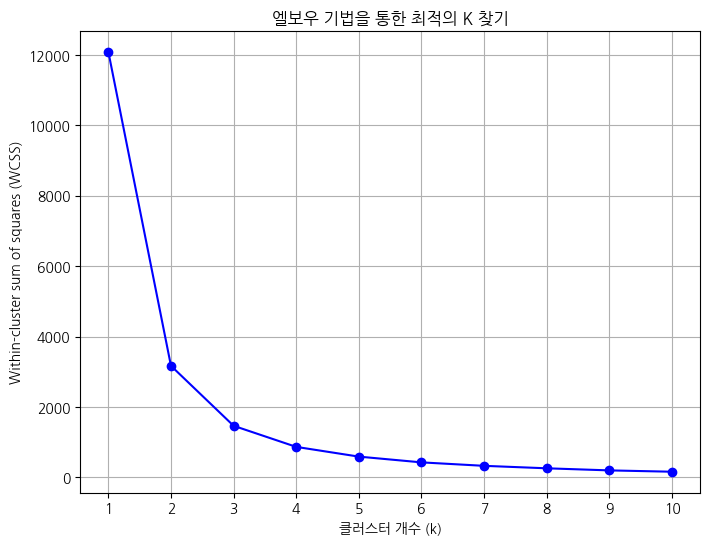

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ✅ 대여소별 연간 평균 대여건수 계산
df_cluster_2025 = df_2025_pred.groupby("대여소")["앙상블_최종예측"].mean().reset_index()
df_cluster_2025.rename(columns={"앙상블_최종예측": "평균_대여건수"}, inplace=True)

# ✅ 엘보우 기법을 위한 K-Means 클러스터 개수 범위 설정
inertia = []
K_range = range(1, 11)  # 1~10개의 클러스터를 테스트

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster[["평균_대여건수"]])
    inertia.append(kmeans.inertia_)  # 클러스터링의 관성값 저장

# ✅ 엘보우 기법 그래프 시각화
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o", linestyle="-", color="b")
plt.xlabel("클러스터 개수 (k)")
plt.ylabel("Within-cluster sum of squares (WCSS)")
plt.title("엘보우 기법을 통한 최적의 K 찾기")
plt.xticks(K_range)
plt.grid()
plt.show()


✅ 대여소별 수요 클러스터링 완료!


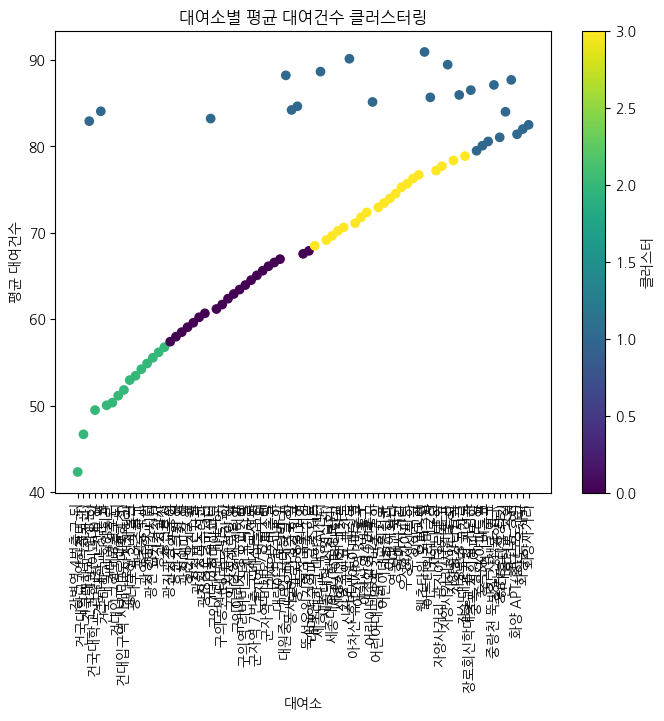

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ✅ 대여소별 연간 평균 대여건수 계산
df_cluster_2025 = df_2025_pred.groupby("대여소")["앙상블_최종예측"].mean().reset_index()
df_cluster_2025.rename(columns={"앙상블_최종예측": "평균_대여건수"}, inplace=True)

# ✅ K-Means 클러스터링 (클러스터 개수 3개 예시: 수요 낮음, 중간, 높음)
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster_2025["클러스터"] = kmeans.fit_predict(df_cluster_2025[["평균_대여건수"]])

# ✅ 클러스터링 결과 확인
print("✅ 대여소별 수요 클러스터링 완료!")

# ✅ 클러스터별 평균 대여건수 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df_cluster_2025["대여소"], df_cluster_2025["평균_대여건수"], c=df_cluster_2025["클러스터"], cmap="viridis")
plt.colorbar(label="클러스터")
plt.xlabel("대여소")
plt.ylabel("평균 대여건수")
plt.title("대여소별 평균 대여건수 클러스터링")
plt.xticks(rotation=90)
plt.show()


In [ ]:
cluster_summary_final_25 = df_cluster_2025.groupby("클러스터")["평균_대여건수"].mean().reset_index()
cluster_summary_final_25.rename(columns={"평균_대여건수": "클러스터별 평균 대여건수"}, inplace=True)
tools.display_dataframe_to_user(name="최종 재배정된 클러스터별 평균 대여건수", dataframe=cluster_summary_final_25)

최종 재배정된 클러스터별 평균 대여건수


In [292]:
# ✅ 클러스터별 대여소 목록 정리
cluster_detail1 = df_cluster_2025.groupby("클러스터")["대여소"].apply(list).reset_index()
cluster_detail1.rename(columns={"대여소": "대여소 목록"}, inplace=True)

tools.display_dataframe_to_user(name="클러스터별 대여소 목록", dataframe=cluster_detail1)

print("✅ 클러스터별 대여소 목록 정리 완료!")


클러스터별 대여소 목록


✅ 클러스터별 대여소 목록 정리 완료!


In [ ]:
import folium
import pandas as pd

# ✅ 설치시기에서 연도만 추출
df["설치연도"] = pd.to_datetime(df["설치시기"]).dt.year

# ✅ 지도 생성 (중심 좌표 설정)
center_lat = df["위도"].mean()
center_lon = df["경도"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# ✅ 클러스터 0과 4번만 필터링
df_filtered = df_cluster_2025[df_cluster_2025["클러스터"].isin([2, 1])]

# ✅ 지도에 기존 클러스터 대여소 마커 추가
for idx, row in df_filtered.iterrows():
    station_name = row["대여소"]
    cluster_label = row["클러스터"]

    # 위도 경도 찾기
    lat_lon = df[df["대여소"] == station_name][["위도", "경도"]].values
    if len(lat_lon) == 0:
        continue
    lat, lon = lat_lon[0]

    # 설치 연도 가져오기
    installation_year = df[df["대여소"] == station_name]["설치연도"].values
    installation_year = installation_year[0] if len(installation_year) > 0 else "정보 없음"

    # 평균 대여건수 가져오기
    avg_rentals = row["평균_대여건수"]

    # 팝업 내용 설정
    popup_text = f"대여소: {station_name}<br>클러스터: {cluster_label}<br>설치 연도: {installation_year}<br>평균 대여건수: {avg_rentals}"

    # 마커 추가 (클러스터 2: 파란색, 클러스터 1: 빨간색)
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="blue" if cluster_label == 2 else "red")
    ).add_to(m)

# ✅ 2023~2024년 신규 설치 대여소 필터링
df_new_install = df[df["설치연도"].isin([2023, 2024])]

# ✅ 신규 설치 대여소를 검정색 마커와 원으로 표시
for idx, row in df_new_install.iterrows():
    station_name = row["대여소"]
    lat, lon = row["위도"], row["경도"]

    # 팝업 내용 설정
    popup_text = f"대여소: {station_name}<br>설치 연도: {row['설치연도']} (신규)"

    # 검정색 마커 추가
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="black")
    ).add_to(m)

    # 주변에 원(circle) 추가 (반경 200m)
    folium.Circle(
        location=[lat, lon],
        radius=200,
        color="black",
        fill=True,
        fill_color="gray",
        fill_opacity=0.3
    ).add_to(m)

# ✅ 지도 출력
m


In [ ]:
# ✅ dates_2025를 X_2025에 다시 추가하여 '대여일자' 컬럼 복원
X_2025["대여일자"] = dates_2025

# ✅ df_2025_pred의 '앙상블_최종예측' 값을 X_2025에 병합 (대여소 + 대여일자 기준)
X_2025 = X_2025.merge(df_2025_pred[["대여소_인코딩", "대여일자", "앙상블_최종예측"]],
                      on=["대여소_인코딩", "대여일자"], how="left")

# ✅ 최종 확인
print("✅ '대여일자' 복원 및 '앙상블_최종예측' 병합 완료!")
print("✅ 병합된 X_2025 shape:", X_2025.shape)
print("✅ 병합된 X_2025 첫 5개 행:\n", X_2025.head())


✅ '대여일자' 복원 및 '앙상블_최종예측' 병합 완료!
✅ 병합된 X_2025 shape: (28835, 15)
✅ 병합된 X_2025 첫 5개 행:
    대여소_인코딩         위도          경도  요일  월      강수여부   전날_강수여부 다음날_공휴일  전날_이용건수  \
0        0  37.535824  127.094162   2  1  0.493218  0.473737       1      NaN   
1        0  37.535824  127.094162   3  1  0.493218  0.473737       1      NaN   
2        0  37.535824  127.094162   4  1  0.493218  0.473737       1      NaN   
3        0  37.535824  127.094162   5  1  0.493218  0.473737       0      NaN   
4        0  37.535824  127.094162   6  1  0.493218  0.473737       1      NaN   

   7일전_이용건수  주간_이동평균_이용건수  월별_이용량_변화율   연속_이용증가일수       대여일자   앙상블_최종예측  
0       NaN     12.000000    3.241865  180.219336 2025-01-01  21.132967  
1       NaN      2.000000    3.241865  180.219336 2025-01-02  19.064410  
2       NaN      2.666667    3.241865  180.219336 2025-01-03  18.788700  
3       NaN      5.666667    3.241865  180.219336 2025-01-04  19.832659  
4       NaN     12.333333    3.241865  180.219336 2025-01

In [ ]:
X_2025

대여소_인코딩         위도          경도  요일   월      강수여부   전날_강수여부 다음날_공휴일  \
0            0  37.535824  127.094162   2   1  0.493218  0.473737       1   
1            0  37.535824  127.094162   3   1  0.493218  0.473737       1   
2            0  37.535824  127.094162   4   1  0.493218  0.473737       1   
3            0  37.535824  127.094162   5   1  0.493218  0.473737       0   
4            0  37.535824  127.094162   6   1  0.493218  0.473737       1   
...        ...        ...         ...  ..  ..       ...       ...     ...   
28830       64  37.538033  127.083557   5  12  0.549661  0.534600       1   
28831       64  37.538033  127.083557   6  12  0.549661  0.534600       0   
28832       64  37.538033  127.083557   0  12  0.549661  0.534600       1   
28833       64  37.538033  127.083557   1  12  0.549661  0.534600       1   
28834       64  37.538033  127.083557   2  12  0.549661  0.534600       1   

       전날_이용건수  7일전_이용건수  주간_이동평균_이용건수  월별_이용량_변화율   연속_이용증가일수       대여일자  \
0          NaN       NaN     12.000000    3.241865  180.219336 2025-01-01   
1          NaN       NaN      2.000000    3.241865  180.219336 2025-01-02   
2          NaN       NaN      2.666667    3.241865  180.219336 2025-01-03   
3          NaN       NaN      5.666667    3.241865  180.219336 2025-01-04   
4          NaN       NaN     12.333333    3.241865  180.219336 2025-01-05   
...        ...       ...           ...         ...         ...        ...   
28830      NaN       NaN      3.809524    1.868608  326.955902 2025-12-27   
28831      NaN       NaN     23.238095    1.868608  326.955902 2025-12-28   
28832      NaN       NaN     31.257143    1.868608  326.955902 2025-12-29   
28833      NaN       NaN     31.257143    1.868608  326.955902 2025-12-30   
28834      NaN       NaN      7.571429    1.868608  326.955902 2025-12-31   

        앙상블_최종예측  
0      21.132967  
1      19.064410  
2      18.788700  
3      19.832659  
4      20.501860  
...          ...  
28830  53.952364  
28831  56.758613  
28832  48.502487  
28833  44.533873  
28834  48.646771  

[28835 rows x 15 columns]

In [ ]:
import pandas as pd

# ✅ 2026년 날짜 생성
date_range_2026 = pd.date_range(start="2026-01-01", end="2026-12-31", freq="D")

# ✅ 모든 대여소 목록 가져오기
unique_stations = train_data["대여소_인코딩"].unique()

# ✅ 대여소별 날짜 조합 생성
X_2026_list = []
for station in unique_stations:
    temp_df = pd.DataFrame({"대여일자": date_range_2026})
    temp_df["대여소_인코딩"] = station
    X_2026_list.append(temp_df)

# ✅ 하나의 데이터프레임으로 합치기
X_2026 = pd.concat(X_2026_list, ignore_index=True)

# ✅ 날짜 관련 피처 추가
X_2026["연도"] = X_2026["대여일자"].dt.year
X_2026["월"] = X_2026["대여일자"].dt.month
X_2026["요일"] = X_2026["대여일자"].dt.weekday  # 월(0) ~ 일(6)

# ✅ 계절성 반영 (월별 평균 패턴 적용)
train_data_numeric = train_data.copy()
for col in ["강수여부", "전날_강수여부", "월별_이용량_변화율", "연속_이용증가일수"]:
    if train_data_numeric[col].dtype.name == "category":
        train_data_numeric[col] = train_data_numeric[col].astype("int")

monthly_avg = train_data_numeric.groupby("월")[["강수여부", "전날_강수여부", "월별_이용량_변화율", "연속_이용증가일수"]].mean().reset_index()
X_2026 = X_2026.merge(monthly_avg, on="월", how="left")

# ✅ 공휴일 반영 (2025년 데이터 기반)
X_2026["다음날_공휴일"] = 0
holiday_dates = X_2025[X_2025["다음날_공휴일"] == 1]["대여일자"].dt.dayofyear.unique()
X_2026.loc[X_2026["대여일자"].dt.dayofyear.isin(holiday_dates), "다음날_공휴일"] = 1

# ✅ Prophet을 사용하여 `전날_이용건수`, `7일전_이용건수` 예측 (대여소별 예측)
prophet_predictions = []
for station in unique_stations:
    prophet_train = df_2025_pred[df_2025_pred["대여소_인코딩"] == station][["대여일자", "앙상블_최종예측"]].rename(columns={"대여일자": "ds", "앙상블_최종예측": "y"})
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(prophet_train)
    future_dates = prophet_model.make_future_dataframe(periods=365)
    forecast = prophet_model.predict(future_dates)
    forecast["대여소_인코딩"] = station
    forecast = forecast[["ds", "대여소_인코딩", "yhat"]].rename(columns={"ds": "대여일자", "yhat": "전날_이용건수"})
    prophet_predictions.append(forecast)

# ✅ Prophet 예측값 반영
prophet_predictions_df = pd.concat(prophet_predictions, ignore_index=True)
X_2026 = X_2026.merge(prophet_predictions_df, on=["대여일자", "대여소_인코딩"], how="left")

# ✅ 7일전 이용건수 예측값 추가
X_2026["7일전_이용건수"] = X_2026["전날_이용건수"].shift(7).fillna(method="bfill")

# ✅ 주간 이동평균 이용건수 (대여소별 이동평균 적용)
X_2026["주간_이동평균_이용건수"] = df_2025_pred.groupby(["대여소_인코딩", df_2025_pred["대여일자"].dt.isocalendar().week])["앙상블_최종예측"].transform("mean")

# ✅ 대여소별 위도, 경도 정보 추가
station_geo_info = train_data[["대여소_인코딩", "위도", "경도"]].drop_duplicates()

# ✅ X_2026에 대여소별 위도, 경도 추가
X_2026 = X_2026.merge(station_geo_info, on="대여소_인코딩", how="left")
dates_2026 = X_2026["대여일자"]

# ✅ 불필요한 컬럼 제거
X_2026 = X_2026[filtered_features]

X_2026

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/lpf_cy8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/a82_h9sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60559', 'data', 'file=/tmp/tmp9dw32dcw/lpf_cy8v.json', 'init=/tmp/tmp9dw32dcw/a82_h9sm.json', 'output', 'file=/tmp/tmp9dw32dcw/prophet_modelybx5pwr0/prophet_model-20250218050632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/2o2j69u_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/4gwe9s3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

대여소_인코딩         위도          경도  요일   월      강수여부   전날_강수여부  다음날_공휴일  \
0            0  37.535824  127.094162   3   1  0.493218  0.473737        1   
1            0  37.535824  127.094162   4   1  0.493218  0.473737        1   
2            0  37.535824  127.094162   5   1  0.493218  0.473737        1   
3            0  37.535824  127.094162   6   1  0.493218  0.473737        0   
4            0  37.535824  127.094162   0   1  0.493218  0.473737        1   
...        ...        ...         ...  ..  ..       ...       ...      ...   
28830       64  37.538033  127.083557   6  12  0.549661  0.534600        1   
28831       64  37.538033  127.083557   0  12  0.549661  0.534600        0   
28832       64  37.538033  127.083557   1  12  0.549661  0.534600        1   
28833       64  37.538033  127.083557   2  12  0.549661  0.534600        1   
28834       64  37.538033  127.083557   3  12  0.549661  0.534600        1   

         전날_이용건수   7일전_이용건수  주간_이동평균_이용건수  월별_이용량_변화율   연속_이용증가일수  
0      28.338183  28.338183     22.224769    3.241865  180.219336  
1      27.308949  28.338183     22.224769    3.241865  180.219336  
2      27.784804  28.338183     22.224769    3.241865  180.219336  
3      28.370718  28.338183     22.224769    3.241865  180.219336  
4      28.639042  28.338183     22.224769    3.241865  180.219336  
...          ...        ...           ...         ...         ...  
28830  63.214668  70.301811     55.497962    1.868608  326.955902  
28831  54.865300  61.570400     55.497962    1.868608  326.955902  
28832  51.265904  57.553190     46.368430    1.868608  326.955902  
28833  57.605734  63.443547     46.368430    1.868608  326.955902  
28834  58.063375  63.424979     46.368430    1.868608  326.955902  

[28835 rows x 13 columns]

In [ ]:
# ✅ 1. 2021~2025년 학습 데이터와 2026년 예측 데이터를 준비

# ✅ X_train_final 생성 (X_2025를 기준으로 기존 학습 데이터 결합)
X_train_final = pd.concat([X_train_final, X_2025.drop(columns=["앙상블_최종예측"], errors="ignore")], axis=0)

# ✅ y_train_final 생성 (X_2025의 앙상블 예측값을 학습 데이터로 활용)
y_train_final = pd.concat([y_train_final, df_2025_pred["앙상블_최종예측"]], axis=0).reset_index(drop=True)

# ✅ 2026년 예측을 위한 데이터 준비 (2026년 데이터를 위한 feature set)
X_2026 = X_2026[filtered_features]  # 선택된 feature만 사용

# ✅ '대여일자' 컬럼 삭제 (이미 Prophet을 위해 따로 저장됨)
X_train_final = X_train_final.drop(columns=["대여일자"], errors="ignore")
X_2026 = X_2026.drop(columns=["대여일자"], errors="ignore")

# ✅ 최종 확인
print("✅ '대여일자' 컬럼 삭제 및 '앙상블_최종예측'을 y_train_final로 이동 완료!")
print(f"X_train_final shape after processing: {X_train_final.shape}")
print(f"y_train_final shape after processing: {y_train_final.shape}")
print(f"X_2026 shape after processing: {X_2026.shape}")


✅ '대여일자' 컬럼 삭제 및 '앙상블_최종예측'을 y_train_final로 이동 완료!
X_train_final shape after processing: (113079, 13)
y_train_final shape after processing: (113079,)
X_2026 shape after processing: (28835, 13)


In [ ]:
# ✅ y_train_final 값 확인
print("✅ NaN 개수:", y_train_final.isna().sum())
print("✅ inf 개수:", (y_train_final == float("inf")).sum())
print("✅ -inf 개수:", (y_train_final == float("-inf")).sum())
print("✅ 최대값:", y_train_final.max())
print("✅ 최소값:", y_train_final.min())

✅ NaN 개수: 0
✅ inf 개수: 0
✅ -inf 개수: 0
✅ 최대값: 232.0
✅ 최소값: 1.0


In [ ]:
# ✅ 모든 category 변수 찾기 (2021~2025년 학습 데이터 기준)
categorical_features = X_train_final.select_dtypes(include=['category', 'object']).columns.tolist()

# ✅ LightGBM & XGBoost에서 categorical_feature가 일관되도록 설정
for col in categorical_features:
    X_train_final[col] = X_train_final[col].astype("category")
    X_2026[col] = X_2026[col].astype("category")

# ✅ LightGBM 모델 설정
lgb_model_final = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    categorical_feature=categorical_features  # ✅ LightGBM에서 카테고리 변수 자동 적용
)

# ✅ XGBoost 모델 설정 (enable_categorical=True 추가)
xgb_model_final = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    enable_categorical=True  # ✅ XGBoost에서 카테고리 변수 자동 적용
)

# ✅ LightGBM & XGBoost 학습 (2021~2025년 데이터 사용, 로그 변환 없이)
lgb_model_final.fit(X_train_final, y_train_final)
xgb_model_final.fit(X_train_final, y_train_final)

# ✅ 2026년 예측 수행 (예측 후 exp 변환 없이)
y_pred_lgb_2026 = lgb_model_final.predict(X_2026)
y_pred_xgb_2026 = xgb_model_final.predict(X_2026)

# ✅ 확인
print("✅ 변환된 카테고리 변수:", categorical_features)


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=다음날_공휴일, categorical_column=7 will be ignored. Current value: categorical_feature=다음날_공휴일
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 113079, number of used features: 13
[LightGBM] [Info] Start training from score 54.187500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [ ]:
# ✅ 데이터 크기 확인
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")


X_train_final shape: (113079, 13)
y_train_final shape: (141914,)


In [ ]:
# ✅ Prophet 모델 새로 생성 (튜닝 적용)
prophet_model_final = Prophet(
    growth="linear",
    changepoint_prior_scale=0.01,   # 트렌드 변화를 부드럽게 조정
    seasonality_prior_scale=10.0,   # 계절성 반영 강도
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative"  # 계절성을 비율적으로 반영하여 변화 감지 개선
)

# ✅ Prophet 데이터 준비 (2021~2025년 데이터 기반)
prophet_train_final = df_2025_pred[["대여일자", "앙상블_최종예측"]].rename(columns={"대여일자": "ds", "앙상블_최종예측": "y"})

# ✅ Prophet 모델 학습
prophet_model_final.fit(prophet_train_final)

# ✅ 예측 수행 (2026년 기간 설정)
future_2026 = prophet_model_final.make_future_dataframe(periods=len(X_2026))
forecast_2026 = prophet_model_final.predict(future_2026)

# ✅ 2025년 데이터의 최대값 기반으로 99% 퍼센타일 제한
#max_threshold = df_2025_pred["앙상블_최종예측"].max() * 1.2
y_pred_prophet_2026 = forecast_2026["yhat"].clip(lower=0, #upper=max_threshold
                                                 ).values[:len(X_2026)]



from sklearn.preprocessing import MinMaxScaler

# ✅ Prophet 예측값 크기 조정 (LightGBM과 XGBoost 값의 범위에 맞춤)
scaler = MinMaxScaler(feature_range=(y_pred_lgb_2026.min()-10, y_pred_xgb_2026.max()+180))
y_pred_prophet_2026_scaled = scaler.fit_transform(y_pred_prophet_2026.reshape(-1, 1)).flatten()

# ✅ 최종 앙상블 예측 (Prophet 조정값 반영)
ensemble_2026 = (y_pred_lgb_2026 + y_pred_xgb_2026 + y_pred_prophet_2026_scaled) / 3

# ✅ 2026년 예측 결과 데이터프레임 생성 (대여소 이름 포함)
df_2026_pred = pd.DataFrame({
    "대여소_인코딩": X_2026["대여소_인코딩"],
    "대여일자": dates_2026,
    "LightGBM_예측": y_pred_lgb_2026,
    "XGBoost_예측": y_pred_xgb_2026,
    "Prophet_예측": y_pred_prophet_2026_scaled,
    "앙상블_최종예측": ensemble_2026
})

# ✅ 대여소 인코딩 → 대여소 이름 매핑 추가
station_mapping = train_data[["대여소_인코딩", "대여소"]].drop_duplicates()
df_2026_pred = df_2026_pred.merge(station_mapping, on="대여소_인코딩", how="left")

# ✅ "대여소_인코딩" 컬럼 제거하고 "대여소" 컬럼을 앞으로 정렬
df_2026_pred = df_2026_pred[["대여소", "대여일자", "LightGBM_예측", "XGBoost_예측", "Prophet_예측", "앙상블_최종예측"]]

# ✅ 최종 확인
print("✅ 2026년 대여소별 일별 예측 완료! (대여소 이름 표시)")
df_2026_pred.head(20)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/g1ajqmtw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw32dcw/q4vzr9tm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47399', 'data', 'file=/tmp/tmp9dw32dcw/g1ajqmtw.json', 'init=/tmp/tmp9dw32dcw/q4vzr9tm.json', 'output', 'file=/tmp/tmp9dw32dcw/prophet_modelslc7gc_6/prophet_model-20250218063825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:38:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ 2026년 대여소별 일별 예측 완료! (대여소 이름 표시)


대여소       대여일자  LightGBM_예측  XGBoost_예측  Prophet_예측   앙상블_최종예측
0   강변역 4번출구 뒤 2026-01-01    23.630270   24.359858   12.115924  20.035350
1   강변역 4번출구 뒤 2026-01-02    23.606240   24.441971   12.140761  20.062991
2   강변역 4번출구 뒤 2026-01-03    23.673887   24.460493   12.195013  20.109798
3   강변역 4번출구 뒤 2026-01-04    23.539238   24.503754   12.128788  20.057260
4   강변역 4번출구 뒤 2026-01-05    23.424557   24.398184   12.108751  19.977164
5   강변역 4번출구 뒤 2026-01-06    23.566642   24.172762   12.100139  19.946514
6   강변역 4번출구 뒤 2026-01-07    23.600162   24.319712   12.086576  20.002150
7   강변역 4번출구 뒤 2026-01-08    23.718691   24.354956   12.128728  20.067458
8   강변역 4번출구 뒤 2026-01-09    23.717450   24.446804   12.135569  20.099941
9   강변역 4번출구 뒤 2026-01-10    23.794481   24.469946   12.171999  20.145475
10  강변역 4번출구 뒤 2026-01-11    23.659832   24.513206   12.088742  20.087260
11  강변역 4번출구 뒤 2026-01-12    23.481657   24.351103   12.054177  19.962312
12  강변역 4번출구 뒤 2026-01-13    23.566642   24.099621   12.034402  19.900222
13  강변역 4번출구 뒤 2026-01-14    23.632334   24.276182   12.013847  19.974121
14  강변역 4번출구 뒤 2026-01-15    23.750863   24.311426   12.054118  20.038802
15  강변역 4번출구 뒤 2026-01-16    23.717450   24.433039   12.064407  20.071632
16  강변역 4번출구 뒤 2026-01-17    23.778885   24.456181   12.110233  20.115099
17  강변역 4번출구 뒤 2026-01-18    23.659832   24.499441   12.041970  20.067081
18  강변역 4번출구 뒤 2026-01-19    23.431212   24.374041   12.028642  19.944631
19  강변역 4번출구 뒤 2026-01-20    23.566642   24.099621   12.036071  19.900778

In [ ]:
df_2026_pred.describe()

대여일자   LightGBM_예측    XGBoost_예측  \
count                          28835  28835.000000  28835.000000   
mean   2026-07-02 00:00:00.000000256     52.190788     52.563313   
min              2026-01-01 00:00:00     22.013847     21.445827   
25%              2026-04-02 00:00:00     45.998613     46.263571   
50%              2026-07-02 00:00:00     55.395020     55.408733   
75%              2026-10-01 00:00:00     62.887770     62.040058   
max              2026-12-31 00:00:00     80.082048     82.266708   
std                              NaN     13.696669     14.175824   

         Prophet_예측      앙상블_최종예측  
count  28835.000000  28835.000000  
mean     115.330861     73.361655  
min       12.013847     19.900222  
25%       61.698521     51.544150  
50%      106.499194     70.146372  
75%      165.239727     94.698821  
max      262.266708    136.512026  
std       63.755204     27.309163

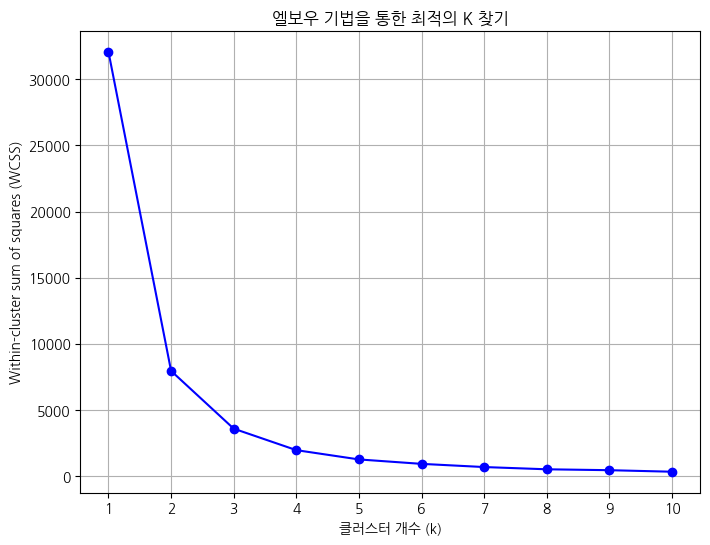

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ✅ 대여소별 연간 평균 대여건수 계산
df_cluster = df_2026_pred.groupby("대여소")["앙상블_최종예측"].mean().reset_index()
df_cluster.rename(columns={"앙상블_최종예측": "평균_대여건수"}, inplace=True)

# ✅ 엘보우 기법을 위한 K-Means 클러스터 개수 범위 설정
inertia = []
K_range = range(1, 11)  # 1~10개의 클러스터를 테스트

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster[["평균_대여건수"]])
    inertia.append(kmeans.inertia_)  # 클러스터링의 관성값 저장

# ✅ 엘보우 기법 그래프 시각화
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o", linestyle="-", color="b")
plt.xlabel("클러스터 개수 (k)")
plt.ylabel("Within-cluster sum of squares (WCSS)")
plt.title("엘보우 기법을 통한 최적의 K 찾기")
plt.xticks(K_range)
plt.grid()
plt.show()


✅ 대여소별 수요 클러스터링 완료!


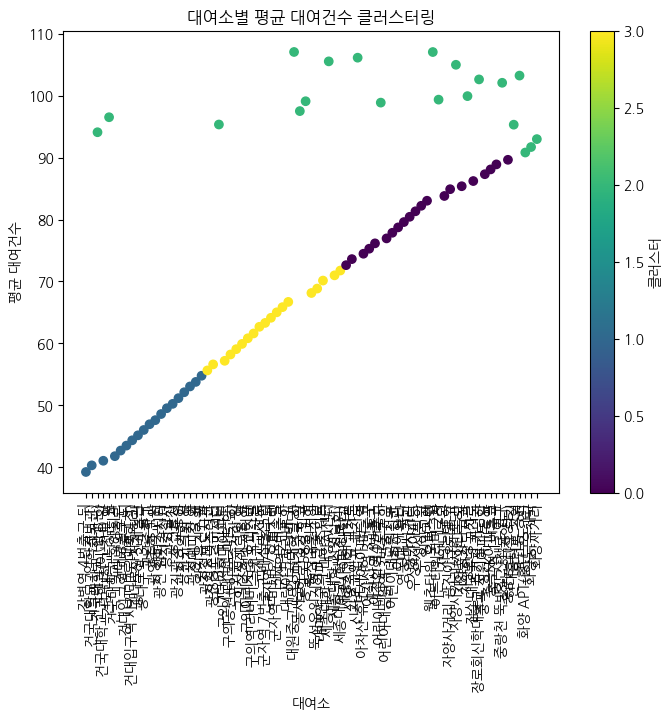

올바르게 재배정된 클러스터별 평균 대여건수


✅ 클러스터 번호를 평균 대여건수 기준으로 정확하게 재배정 완료! (0이 가장 적고, 3이 가장 많음)


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ✅ 데이터 재업로드 필요 (초기화됨)
# df_2026_pred를 다시 불러와야 함

# ✅ 대여소별 연간 평균 대여건수 계산
df_cluster_2026 = df_2026_pred.groupby("대여소")["앙상블_최종예측"].mean().reset_index()
df_cluster_2026.rename(columns={"앙상블_최종예측": "평균_대여건수"}, inplace=True)

# ✅ K-Means 클러스터링 (클러스터 개수 4개)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster_2026["클러스터"] = kmeans.fit_predict(df_cluster_2026[["평균_대여건수"]])


# ✅ 클러스터링 결과 확인
print("✅ 대여소별 수요 클러스터링 완료!")

# ✅ 클러스터별 평균 대여건수 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df_cluster_2026["대여소"], df_cluster_2026["평균_대여건수"], c=df_cluster_2026["클러스터"], cmap="viridis")
plt.colorbar(label="클러스터")
plt.xlabel("대여소")
plt.ylabel("평균 대여건수")
plt.title("대여소별 평균 대여건수 클러스터링")
plt.xticks(rotation=90)
plt.show()

# ✅ 클러스터별 평균 대여건수 다시 확인
cluster_summary_final = df_cluster_2026.groupby("클러스터")["평균_대여건수"].mean().reset_index()
cluster_summary_final.rename(columns={"평균_대여건수": "클러스터별 평균 대여건수"}, inplace=True)


tools.display_dataframe_to_user(name="올바르게 재배정된 클러스터별 평균 대여건수", dataframe=cluster_summary_final)

print("✅ 클러스터 번호를 평균 대여건수 기준으로 정확하게 재배정 완료! (0이 가장 적고, 3이 가장 많음)")

In [ ]:
# ✅ 클러스터별 대여소 목록 정리
cluster_detail = df_cluster_2026.groupby("클러스터")["대여소"].apply(list).reset_index()
cluster_detail.rename(columns={"대여소": "대여소 목록"}, inplace=True)

tools.display_dataframe_to_user(name="클러스터별 대여소 목록", dataframe=cluster_detail)

print("✅ 클러스터별 대여소 목록 정리 완료!")


클러스터별 대여소 목록


✅ 클러스터별 대여소 목록 정리 완료!


In [ ]:
# ✅ 재배정된 클러스터 정보를 반영하여 2025년과 2026년의 클러스터링 비교 (0~3 그룹)

comparison_results = {}

for cluster in range(4):  # 0~3 그룹
    # ✅ 2025년 해당 클러스터 대여소 (재배정된 클러스터 값 반영)
    df_cluster_2025_group = df_cluster_2025[df_cluster_2025["클러스터"] == cluster]

    # ✅ 2026년 해당 클러스터 대여소 (재배정된 클러스터 값 반영)
    df_cluster_2026_group = df_cluster_2026[df_cluster_2026["클러스터"] == cluster]

    # ✅ 2025년에 해당 그룹이었던 대여소가 2026년에 어디로 이동했는지 확인
    df_merged = df_cluster_2025_group.merge(df_cluster_2026, on="대여소", suffixes=("_2025", "_2026"), how="left")

    # ✅ 2025년 특정 그룹이었던 대여소가 2026년에 다른 클러스터로 이동한 경우 확인
    df_moved = df_merged[df_merged["클러스터_2025"] != df_merged["클러스터_2026"]]

    # ✅ 2026년에 특정 그룹이 되었지만 2025년에는 다른 그룹이었던 대여소 확인
    df_cluster_2026_moved = df_cluster_2026_group.merge(df_cluster_2025, on="대여소", suffixes=("_2026", "_2025"), how="left")
    df_cluster_2026_moved = df_cluster_2026_moved[df_cluster_2026_moved["클러스터_2025"] != cluster]

    # ✅ 데이터 저장
    comparison_results[f"2025년 {cluster}그룹에서 이동한 대여소"] = df_moved
    comparison_results[f"2026년 {cluster}그룹으로 이동한 대여소"] = df_cluster_2026_moved


for name, df1 in comparison_results.items():
    tools.display_dataframe_to_user(name=name, dataframe=df1)

print("✅ 2025년과 2026년의 모든 클러스터(0~3) 비교 완료! (재배정된 클러스터 반영)")


2025년 0그룹에서 이동한 대여소


2026년 0그룹으로 이동한 대여소


2025년 1그룹에서 이동한 대여소


2026년 1그룹으로 이동한 대여소


2025년 2그룹에서 이동한 대여소


2026년 2그룹으로 이동한 대여소


2025년 3그룹에서 이동한 대여소


2026년 3그룹으로 이동한 대여소


✅ 2025년과 2026년의 모든 클러스터(0~3) 비교 완료! (재배정된 클러스터 반영)


In [ ]:
import folium

# ✅ 설치시기에서 연도만 추출
df["설치연도"] = pd.to_datetime(df["설치시기"]).dt.year

# ✅ 지도 생성 (중심 좌표 설정)
center_lat = df["위도"].mean()
center_lon = df["경도"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# ✅ 클러스터 1과 2번만 필터링
df_filtered = df_cluster_2025[df_cluster_2025["클러스터"].isin([2, 1])]

# ✅ 지도에 기존 클러스터 대여소 마커 추가
for idx, row in df_filtered.iterrows():
    station_name = row["대여소"]
    cluster_label = row["클러스터"]

    # 위도 경도 찾기
    lat_lon = df[df["대여소"] == station_name][["위도", "경도"]].values
    if len(lat_lon) == 0:
        continue
    lat, lon = lat_lon[0]

    # 설치 연도 가져오기
    installation_year = df[df["대여소"] == station_name]["설치연도"].values
    installation_year = installation_year[0] if len(installation_year) > 0 else "정보 없음"

    # 평균 대여건수 가져오기
    avg_rentals = row["평균_대여건수"]

    # 팝업 내용 설정
    popup_text = f"대여소: {station_name}<br>클러스터: {cluster_label}<br>설치 연도: {installation_year}<br>평균 대여건수: {avg_rentals}"

    # 마커 추가 (클러스터 2: 파란색, 클러스터 1: 빨간색)
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="blue" if cluster_label == 2 else "red")
    ).add_to(m)

# ✅ 2023~2024년 신규 설치 대여소 필터링
df_new_install = df[df["설치연도"].isin([2023, 2024])]

# ✅ 신규 설치 대여소를 검정색 마커와 원으로 표시
for idx, row in df_new_install.iterrows():
    station_name = row["대여소"]
    lat, lon = row["위도"], row["경도"]

    # 팝업 내용 설정
    popup_text = f"대여소: {station_name}<br>설치 연도: {row['설치연도']} (신규)"

    # 검정색 마커 추가
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="black")
    ).add_to(m)

    # 주변에 원(circle) 추가 (반경 200m)
    folium.Circle(
        location=[lat, lon],
        radius=200,
        color="black",
        fill=True,
        fill_color="gray",
        fill_opacity=0.3
    ).add_to(m)

import folium


# ✅ 특정 대여소 목록
target_stations = ["광진광장 교통섬", "광진구의회 앞", "광진구청 앞", "광진메디칼 앞", "광진유진스웰"]

# ✅ 지정된 대여소를 초록색 마커로 표시
for station in target_stations:
    lat_lon = df[df["대여소"] == station][["위도", "경도"]].values
    if len(lat_lon) == 0:
        continue
    lat, lon = lat_lon[0]

    # 팝업 내용 설정
    popup_text = f"대여소: {station}<br>26년 최하그룹으로 바뀜"

    # 초록색 마커 추가
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="green")
    ).add_to(m)

# ✅ 지도 출력
m

In [ ]:
m.save("map_add.html")